# Test walking experience

This Notebooks contains calculation testing to determine walking experience in different areas of a city. Here, a specific area within Guadalajara is evaluated.

## Import libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-07-26 16:06:32 Configured OSMnx 1.1.2
2023-07-26 16:06:32 HTTP response caching is on


## Study area

<AxesSubplot: >

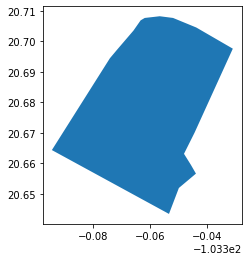

In [3]:
area_gdf = gpd.read_file('../../data/processed/walking_experience/test_area.geojson')
area_gdf.plot()

## Gather data

In [4]:
gdf_tmp = area_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

### Street network

In [5]:
_, nodes, edges = aup.graph_from_hippo(area_gdf, schema='osmnx',
                    edges_folder='edges_speed', nodes_folder='nodes')

2023-07-26 16:12:26 Created graph from node/edge GeoDataFrames


In [6]:
edges = edges.reset_index()
print(edges.shape)
edges.head(2)

(14019, 22)


,u,v,key,osmid,oneway,lanes,name,highway,length,geometry,...,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
0,4047340629,6289574174,0,783521060,True,1,Macrobús,service,260.912,"LINESTRING (-103.34616 20.66722, -103.34727 20...",...,no,None,None,70,None,None,None,None,3.795417,4.124637
1,801436652,8370446792,0,113540626,False,None,Calle Colegiales,residential,56.425,"LINESTRING (-103.34626 20.67050, -103.34636 20...",...,None,None,None,None,None,None,None,None,3.755774,0.901412


In [7]:
nodes = nodes.reset_index()
print(nodes.shape)
nodes.head(2)

(7100, 5)


,osmid,x,y,street_count,geometry
0,28791285,-103.386953,20.674556,3,POINT (-103.38695 20.67456)
1,28791315,-103.356460,20.674864,4,POINT (-103.35646 20.67486)


<AxesSubplot: >

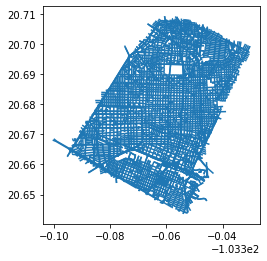

In [8]:
edges.plot()

### NDVI

In [9]:
query = f"SELECT * FROM raster_analysis.ndvi_analysis_hex WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\') AND res=11"
ndvi = aup.gdf_from_query(query, geometry_col='geometry')
print(ndvi.shape)
ndvi.head(4)

(10508, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8b498c96a45cfff,"POLYGON ((-103.34721 20.69516, -103.34703 20.6...",11,0.133119,0.038973,0.139180,0.171891,0.072157,0.099735,-0.001184,Guadalajara
1,8b498c96a512fff,"POLYGON ((-103.34324 20.68944, -103.34307 20.6...",11,0.080185,0.024420,0.089155,0.106786,0.032623,0.074163,-0.000706,Guadalajara
2,8b498c96a521fff,"POLYGON ((-103.34609 20.68820, -103.34591 20.6...",11,0.049651,0.022087,0.055419,0.074674,0.024812,0.049862,-0.000989,Guadalajara
3,8b498c96a49afff,"POLYGON ((-103.34038 20.69534, -103.34021 20.6...",11,0.085112,0.019913,0.090015,0.102336,0.063246,0.039090,-0.000702,Guadalajara


<AxesSubplot: >

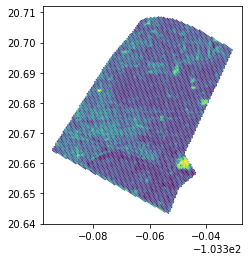

In [10]:
ndvi.plot('ndvi_mean')

### Estructura urbana - Frente de manzana - Marco Geoestadístico

In [11]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
entorno = aup.gdf_from_query(query, geometry_col='geometry')
print(entorno.shape)
entorno.head(4)

(11974, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1403900012380019,14,039,0001,2380,019,03117,00001,3,Pelícano,...,3,1,3,3,3,3,1,1,11,0
1,1403900011062021,14,039,0001,1062,021,03273,00002,1,Martín Casillas,...,3,1,1,3,3,3,1,1,11,0
2,1403900015313008,14,039,0001,5313,008,03157,00007,3,Tormenta,...,3,1,3,3,3,3,1,1,11,0
3,1403900012342005,14,039,0001,2342,005,03120,00004,2,Cerezo,...,3,1,1,3,3,3,1,1,11,0


### DENUE

In [12]:
query = f"SELECT * FROM denue.denue_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
denue = aup.gdf_from_query(query, geometry_col='geometry')
print(denue.shape)
denue.head(4)

(27265, 42)


,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipo_uni_eco,latitud,longitud,fecha_alta,geometry
0,8605860.0,INDO SERVICIOS AGRICOLAS,INDO SERVICIOS AGRICOLAS SA DE CV,115119.0,Otros servicios relacionados con la agricultura,6 a 10 personas,CALLE,JESUS GARCIA,CALLE,GABRIEL RAMOS MILLAN,...,0647,29.0,nan,None,None,Fijo,20.689753,-103.367355,2019-11,POINT (-103.36736 20.68975)
1,1667403.0,CFE,COMISION FEDERAL DE ELECTRICIDAD,221111.0,Generación de electricidad a partir de combust...,6 a 10 personas,CALLE,HUMBOLDT,CALLE,GARIBALDI,...,1363,28.0,3331341300.0,OSCAR.MORENO01@CFE.GOB.MX,None,Fijo,20.681252,-103.343210,2014-12,POINT (-103.34321 20.68125)
2,1842816.0,TALLER OPTICO,None,339113.0,Fabricación de artículos oftálmicos,0 a 5 personas,CALLE,MEZQUITAN,AVENIDA,HIDALGO,...,1344,13.0,3331245066.0,None,None,Fijo,20.677042,-103.353350,2010-07,POINT (-103.35335 20.67704)
3,6766876.0,MINERA PURA GLORIA SA DE CV,MINERA PURA GLORIA SA DE CV,212210.0,Minería de hierro,0 a 5 personas,CALLE,VIDRIO,AVENIDA,ENRIQUE DIAZ DE LEON SUR,...,1838,9.0,3339556924.0,YAZMINLUNA@MINERAPURAGLORIA.MX,None,Fijo,20.667570,-103.359985,2016-10,POINT (-103.35999 20.66757)


In [13]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [14]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

### Censo

In [15]:
query = f"SELECT * FROM censo_mza.censo_mza_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
censo = aup.gdf_from_query(query, geometry_col='geometry')
print(censo.shape)
censo.head(4)

(2846, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,1403900011607001,14,039,0001,1607,001,Urbana,Típica,"POLYGON ((-103.36224 20.67421, -103.36224 20.6...",14,...,None,None,None,None,None,None,None,None,None,None
1,1403900010647021,14,039,0001,0647,021,Urbana,Típica,"POLYGON ((-103.36341 20.69213, -103.36341 20.6...",14,...,26,37,37,26,26,17,None,0,0,0
2,1403900015309023,14,039,0001,5309,023,Urbana,Típica,"POLYGON ((-103.38439 20.66645, -103.38441 20.6...",14,...,0,0,0,0,0,0,0,0,0,0
3,1403900011626012,14,039,0001,1626,012,Urbana,Típica,"POLYGON ((-103.34641 20.67274, -103.34638 20.6...",14,...,0,0,0,0,0,0,0,0,0,0


## Method test

### Street test

In [20]:
max_idx = edges['length'].max()

In [21]:
edge_test = edges.loc[(edges['length']==max_idx)].copy()
edge_test

,u,v,key,osmid,oneway,lanes,name,highway,length,geometry,...,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
11046,1832752151,2978021613,0,"[435034520, 284557003, 131822656, 284556999]",True,2,"['Avenida Adolfo López Mateos Norte', 'Avenida...",trunk,1412.365,"LINESTRING (-103.38243 20.68202, -103.38342 20...",...,None,yes,MEX 23;MEX 54,None,None,None,None,None,3.889553,21.787051


### Area of analysis test

In [22]:
hex_intersect_list = gpd.sjoin(edge_test, ndvi, op='intersects')
hex_intersect_list = list(hex_intersect_list.hex_id.unique())
hex_intersect_list

/home/edgaregurrola/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


['8b498c96d58dfff',
 '8b498c96d588fff',
 '8b498c96d58bfff',
 '8b498c96d4a4fff',
 '8b498c96d4a0fff',
 '8b498c96d4a2fff',
 '8b498c96d484fff',
 '8b498c96d486fff',
 '8b498c96d482fff',
 '8b498c96d49cfff',
 '8b498c96d49efff',
 '8b498c96d49afff',
 '8b498c968869fff',
 '8b498c968b36fff',
 '8b498c96884dfff',
 '8b498c968849fff',
 '8b498c96884bfff',
 '8b498c968ba5fff',
 '8b498c968ba1fff',
 '8b498c968ba3fff',
 '8b498c968b85fff',
 '8b498c968b80fff',
 '8b498c968b83fff',
 '8b498c968b9cfff',
 '8b498c968b98fff',
 '8b498c968b9afff',
 '8b498c968ab4fff',
 '8b498c968ab0fff',
 '8b498c968ab2fff',
 '8b498c968a94fff',
 '8b498c968a96fff']

In [23]:
hex_buffer = gpd.GeoDataFrame(geometry=ndvi.loc[ndvi.hex_id.isin(hex_intersect_list)].to_crs("EPSG:6372").buffer(10)).dissolve().to_crs("EPSG:4326")

In [24]:
hex_study_list = gpd.sjoin(hex_buffer, ndvi, predicate='intersects')
hex_study_list =  list(hex_study_list.hex_id.unique())
hex_study_area = ndvi.loc[ndvi.hex_id.isin(hex_study_list)]
print(hex_study_area.shape)

(77, 11)


/home/edgaregurrola/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot: >

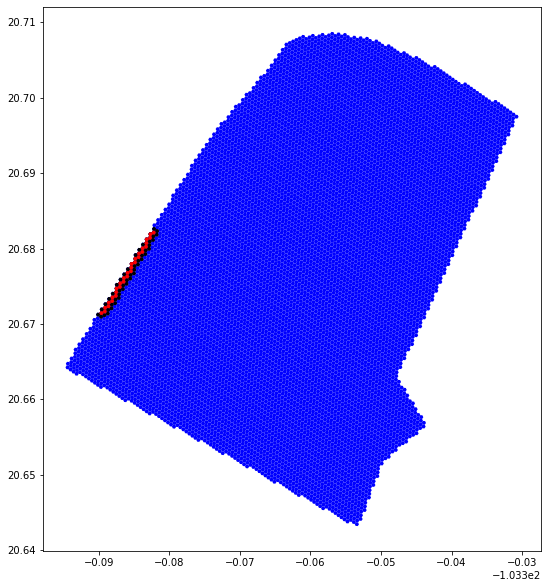

In [25]:
fig,ax = plt.subplots(figsize=(10,10))
ndvi.loc[ndvi.hex_id.isin(hex_intersect_list)].plot(zorder=3, ax=ax, color='red')
hex_study_area.plot(ax=ax, zorder=2, color='black')
ndvi.plot(ax=ax, color='blue')

### Create manzanas gdf

In [26]:
mnz = censo[['CVEGEO','geometry']].copy()

## Assign DENUE to manzanas

In [52]:
denue['cont'] = 1

In [53]:
mnz_denue_df = gpd.sjoin_nearest(denue, mnz).groupby('CVEGEO').sum(numeric_only=True)[['per_ocu_num','cont']].reset_index()
print(mnz_denue_df.shape)
mnz_denue_df.head(4)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(2511, 3)


,CVEGEO,per_ocu_num,cont
0,1403900010030007,11,2
1,1403900010030008,147,8
2,1403900010030009,51,4
3,1403900010030010,108,14


<AxesSubplot: >

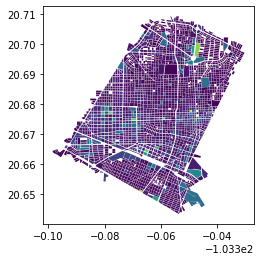

In [54]:
mnz_denue = censo[['CVEGEO','geometry']].merge(mnz_denue_df, on='CVEGEO')
mnz_denue.plot('per_ocu_num')

### Working force - population relation

In [55]:
mnz_pop_work = censo[['POBTOT','CVEGEO','geometry']].merge(mnz_denue[['CVEGEO','per_ocu_num','cont']], on = 'CVEGEO', how='left')

In [56]:
mnz_pop_work.loc[mnz_pop_work.per_ocu_num.isna(),'per_ocu_num'] = 1
mnz_pop_work.loc[mnz_pop_work.POBTOT==0,'POBTOT'] = 1

In [57]:
mnz_pop_work['rel_pop_work'] = mnz_pop_work['POBTOT'] / mnz_pop_work['per_ocu_num']

In [58]:
mnz_pop_work['log_pop_work'] = np.log(mnz_pop_work['rel_pop_work'])

In [59]:
mnz_pop_work['rel_work_workers'] = mnz_pop_work['per_ocu_num']/mnz_pop_work['cont']

<AxesSubplot: >

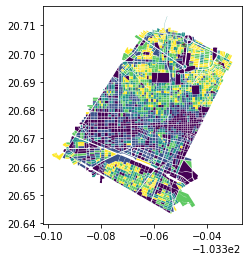

In [60]:
mnz_pop_work.plot('log_pop_work', scheme='quantiles')

### Urban structure

In [34]:
urban_study_area = entorno.clip(hex_study_area)
urban_study_area.head(4)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
9228,1403900011556013,14,039,0001,1556,013,03156,00002,3,Inglaterra,...,3,1,1,3,3,3,1,1,11,0
9229,1403900011556013,14,039,0001,1556,013,04879,00005,4,Adolfo López Mateos Sur,...,3,1,3,3,3,3,1,1,11,0
9226,1403900011556013,14,039,0001,1556,013,06615,00006,1,Juan I. Matute,...,3,1,3,3,3,3,1,1,11,0
9122,1403900011556003,14,039,0001,1556,003,03156,00003,4,Inglaterra,...,3,3,1,3,3,3,1,1,11,0


In [35]:
urban_idx = {}
urban_elements = ['BANQUETA','ALUMPUB','RAMPAS','ARBOLES']

for ue in urban_elements:
    with_length = urban_study_area.to_crs("EPSG:6372").loc[urban_study_area[ue]==1].length.sum()
    without_length = urban_study_area.to_crs("EPSG:6372").loc[urban_study_area[ue]==3].length.sum()
    urban_idx[ue] = round(with_length / (with_length + without_length),3)

In [36]:
urban_idx

{'BANQUETA': 0.992, 'ALUMPUB': 0.745, 'RAMPAS': 0.684, 'ARBOLES': 0.899}

### Population density

In [37]:
censo_study_area = censo.clip(hex_study_area)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [38]:
pobtot = censo_study_area.POBTOT.sum()
area = hex_study_area.to_crs("EPSG:6372").area.sum()/10000

In [39]:
pobtot / area

65.17919036883886

## Data al edge level

In [47]:
edge_idx = edge_test[['u','v','key','highway','length',
          'grade','grade_abs','geometry']]
edge_idx

,u,v,key,highway,length,grade,grade_abs,geometry
11046,1832752151,2978021613,0,trunk,1412.365,0.008,0.008,"LINESTRING (-103.38243 20.68202, -103.38342 20..."


In [48]:
edge_test['dens_pobha'] = pobtot / area

In [49]:
for u in urban_idx.keys():
    edge_test[u] = urban_idx[u]

In [50]:
edge_test

,u,v,key,osmid,oneway,lanes,name,highway,length,geometry,...,junction,service,width,walkspeed,time_min,dens_pobha,BANQUETA,ALUMPUB,RAMPAS,ARBOLES
11046,1832752151,2978021613,0,"[435034520, 284557003, 131822656, 284556999]",True,2,"['Avenida Adolfo López Mateos Norte', 'Avenida...",trunk,1412.365,"LINESTRING (-103.38243 20.68202, -103.38342 20...",...,None,None,None,3.889553,21.787051,65.17919,0.992,0.745,0.684,0.899


In [62]:
work_data = ['per_ocu_num','cont','rel_pop_work','log_pop_work',
            'rel_work_workers']
work_study_area = mnz_pop_work.clip(hex_study_area)

for wd in work_data:
    mean_value = work_study_area[wd].mean()
    edge_test[wd] = mean_value


/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [63]:
edge_test

,u,v,key,osmid,oneway,lanes,name,highway,length,geometry,...,dens_pobha,BANQUETA,ALUMPUB,RAMPAS,ARBOLES,per_ocu_num,cont,rel_pop_work,log_pop_work,rel_work_workers
11046,1832752151,2978021613,0,"[435034520, 284557003, 131822656, 284556999]",True,2,"['Avenida Adolfo López Mateos Norte', 'Avenida...",trunk,1412.365,"LINESTRING (-103.38243 20.68202, -103.38342 20...",...,65.17919,0.992,0.745,0.684,0.899,96.756757,9.83871,1.31625,-1.383131,15.730202


In [66]:
edge_test['ndvi'] = ndvi.loc[ndvi.hex_id.isin(hex_intersect_list)].ndvi_mean.mean()

In [67]:
edge_test

,u,v,key,osmid,oneway,lanes,name,highway,length,geometry,...,BANQUETA,ALUMPUB,RAMPAS,ARBOLES,per_ocu_num,cont,rel_pop_work,log_pop_work,rel_work_workers,ndvi
11046,1832752151,2978021613,0,"[435034520, 284557003, 131822656, 284556999]",True,2,"['Avenida Adolfo López Mateos Norte', 'Avenida...",trunk,1412.365,"LINESTRING (-103.38243 20.68202, -103.38342 20...",...,0.992,0.745,0.684,0.899,96.756757,9.83871,1.31625,-1.383131,15.730202,0.206248


## Functions for study area analysis

In [70]:
hex_gdf = ndvi[['hex_id','geometry']].copy()

In [73]:
def hex_list(edge, hex_gdf):
    hex_intersect_list = gpd.sjoin(edge, hex_gdf, op='intersects')
    hex_intersect_list = list(hex_intersect_list.hex_id.unique())
    return hex_interesct_list

In [74]:
def hex_street(hex_interesct_list, hex_gdf):
    hex_street = hex_gdf.loc[hex_gdf.hex_id.isin(hex_intersect_list)].copy()
    return hex_street

In [72]:
def urban_analysis(hex_street, entorno):
    urban_study_area = entorno.clip(hex_study_area)
    urban_idx = {}
    urban_elements = ['BANQUETA','ALUMPUB','RAMPAS','ARBOLES']

    for ue in urban_elements:
        with_length = urban_study_area.to_crs("EPSG:6372").loc[urban_study_area[ue]==1].length.sum()
        without_length = urban_study_area.to_crs("EPSG:6372").loc[urban_study_area[ue]==3].length.sum()
        urban_idx[ue] = round(with_length / (with_length + without_length),3)
    return urban_idx

In [75]:
def density(hex_street, censo_gdf):
    censo_study_area = censo.clip(hex_street)
    # pobtot / area_ha
    density = censo_study_area.POBTOT.sum() / hex_study_area.to_crs("EPSG:6372").area.sum()/10000
    return density

In [76]:
def work_analysis(hex_street, mnz_pop_work):
    work_data = ['per_ocu_num','cont','rel_pop_work','log_pop_work',
                'rel_work_workers']
    work_study_area = mnz_pop_work.clip(hex_study_area)
    work_idx = {}

    for wd in work_data:
        mean_value = work_study_area[wd].mean()
        work_idx[wd] = mean_value
    return work_idx